# Seismic redatuming

### Author: M.Ravasi

Many processing step in the seismic processing chain lend naturally to the creation and solution of large scale systems of equations. 

One of the most common building blocks of wave-equation-based processing of seismic data is the so-called multi-dimensional convolution (MDC) operator. Such an operator underlies some of the most common algorithms such SRME, IME and interferometry by multi-dimensional deconvolution (MDD) and Marchenko-based redatuming. 

In this notebook we will use the **MDC** linear operator of *Pylops* to create a synthetic dataset and perform its inverse operation by Multi-dimensional deconvolution (MDD).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

### Multi-dimensional convolution (MDC)

The so-called multi-dimensional convolution (MDC) is a chained operator. It is composed of a forward Fourier transform a multi-dimensional integration (as shown in equation below) and an inverse Fourier transform:
    
$$ g^-(t, x_s, x_v) = \mathscr{F}^{-1} \Big( \int_S g^+(f, x_s, x_r)
        \mathscr{F}(R(t, x_r, x_v)) dr \Big)$$

This operation can be discretized 

$$ \mathbf{G^-}= \mathbf{\hat{G}^+} \mathbf{R} $$

and performed by means of a linear operator

$$ \mathbf{\hat{G}^+}= \mathbf{F}^H  \mathbf{G^+} \mathbf{F}$$

where $\mathbf{F}$ is the Fourier transform applied along the time axis  and $\mathbf{g^+}$ is multi-dimensional convolution kernel espressed in the equation above.

Let's start considering a single virtual source

In [2]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]


# Create taper for operator
tap = taper3d(par['nt'], [par['ny'], par['nx']], [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G, Gwav = np.zeros((par['ny'], par['nx'], par['nt'])), np.zeros((par['ny'], par['nx'], par['nt']))
for iy,y0 in enumerate(y):
    G[iy],Gwav[iy] = hyperbolic2d(x-y0, t, t0_G, vrms_G, amp_G, wav)
G, Gwav = G*tap,Gwav*tap

In [3]:
# Add negative part to data and model
m     = np.concatenate((np.zeros((par['nx'], par['nt']-1)),    m), axis=-1)
mwav  = np.concatenate((np.zeros((par['nx'], par['nt']-1)), mwav), axis=-1)
Gwav2 = np.concatenate((np.zeros((par['ny'], par['nx'], par['nt']-1)), Gwav), axis=-1)

Gwav_fft = np.fft.rfft(Gwav2, 2*par['nt']-1, axis=-1)
Gwav_fft = Gwav_fft[...,:par['nfmax']]

MDCop=MDC(Gwav_fft.transpose(2,0,1), nt=2*par['nt']-1, nv=1, dt=par['dt'], dr=par['dx'], 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=3, verb=True);

# Create data
d = MDCop * m.T.flatten()
d = d.reshape(2*par['nt']-1, par['ny'])

Dot test passed, v^T(Opu)=1103.806429 - u^T(Op^Tv)=1103.806429


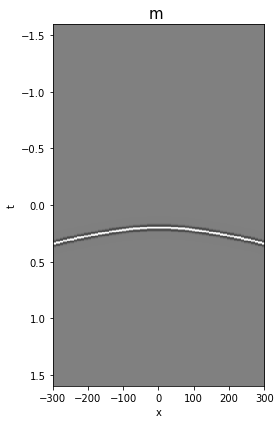

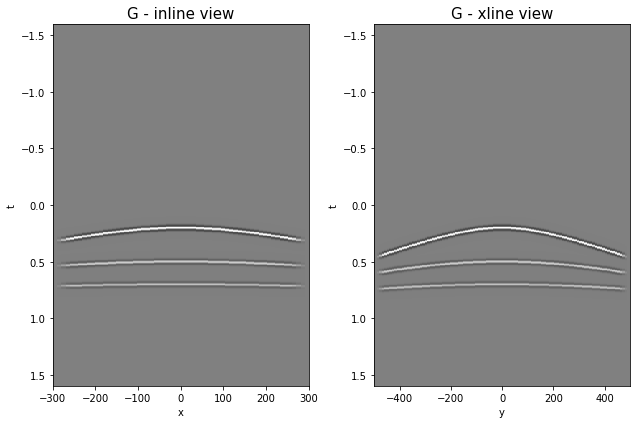

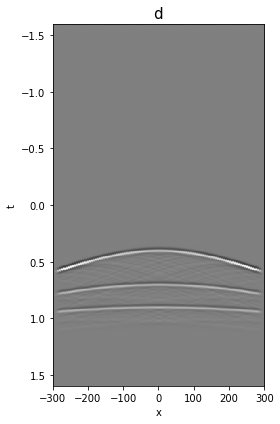

In [4]:
# Plotting
plt.figure(figsize=(4,6))
plt.imshow(mwav.T,aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-np.max(np.abs(mwav)), vmax=np.max(np.abs(mwav)), 
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('m ', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(9,6))
plt.subplot(121)
plt.imshow(Gwav2[int(par['ny']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-np.max(np.abs(mwav)), vmax=np.max(np.abs(mwav)),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('G - inline view', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')

plt.subplot(122)
plt.imshow(Gwav2[:,int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-np.max(np.abs(mwav)), vmax=np.max(np.abs(mwav)), 
           extent=(y.min(),y.max(),t2.max(),t2.min()))
plt.title('G - xline view', fontsize=15)
plt.xlabel('y'),plt.ylabel('t')
plt.tight_layout()

plt.figure(figsize=(4,6))
plt.imshow(d, aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-np.max(np.abs(d)), vmax=np.max(np.abs(d)), 
           extent=(x.min(),x.max(),t2.max(),t2.min()))
plt.title('d', fontsize=15)
plt.xlabel('x'),plt.ylabel('t')
plt.tight_layout()

### Multi-dimensional deconvolution (MDD)

MDD is an ill-solved problem, well-known in the image processing and geophysical community. It aims to remove the effect of the multidimensional convolution kernel or the so-called point-spread function (PSF). It can be written as

$$\mathbf{G^-}= \mathbf{\hat{G}^+} \mathbf{R}$$

or, equivalently, by means of its normal equation

$$\mathbf{R}= (\mathbf{\hat{G}^+}^H\mathbf{\hat{G}^+})^{-1} \mathbf{\hat{G}^+}^H\mathbf{G^-}$$

where $\mathbf{\hat{G}^+}^H\mathbf{\hat{G}^+}$ is generally referred to as blurring operator or PSF.

Dot test passed, v^T(Opu)=2786.081671 - u^T(Op^Tv)=2786.081671
Dot test passed, v^T(Opu)=2871.981809 - u^T(Op^Tv)=2871.981809
 
LSQR            Least-squares solution of  Ax = b
The matrix A has    80699 rows  and    48739 cols
damp = 1.00000000000000e-04   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.920e+02  2.920e+02    1.0e+00  4.4e-01
     1  0.00000e+00   1.896e+02  1.896e+02    6.5e-01  6.8e-01   1.7e+02  1.0e+00
     2  0.00000e+00   1.310e+02  1.310e+02    4.5e-01  4.2e-01   2.5e+02  2.4e+00
     3  0.00000e+00   1.000e+02  1.000e+02    3.4e-01  2.9e-01   3.2e+02  3.8e+00
     4  0.00000e+00   8.067e+01  8.067e+01    2.8e-01  2.2e-01   3.7e+02  5.4e+00
     5  0.00000e+00   6.597e+01  6.597e+01    2.3e-01  1.8e-01   4.1e+02  7.2e+00
     6  0.00000e+00   5.681e+01  5.681e+01    1.9e-01  1.5e-01   4

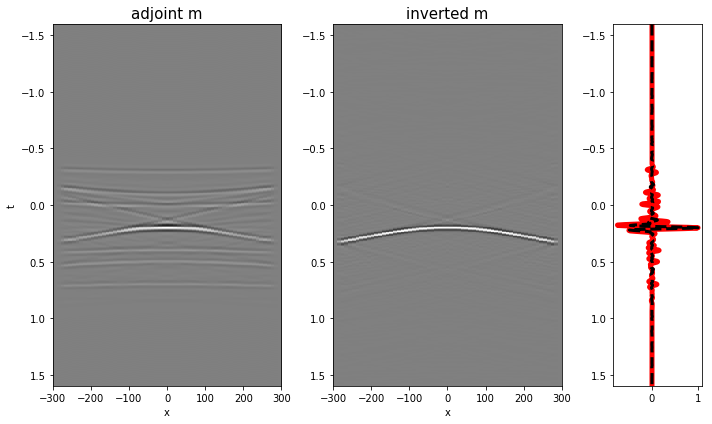

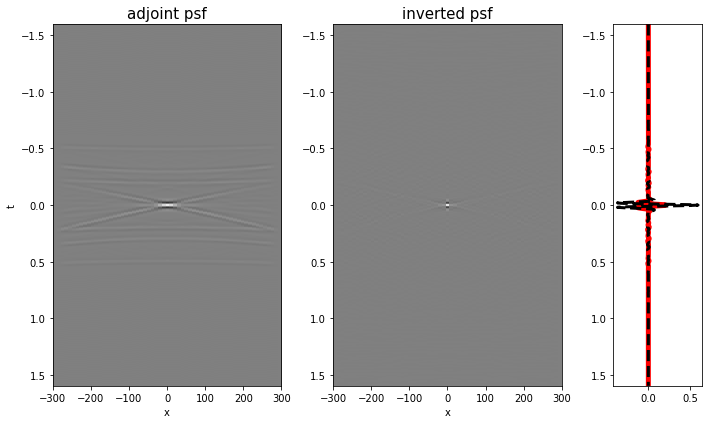

In [5]:
# Invert for model (MDD)
minv,madj,psfinv,psfadj = MDD(Gwav2, d.T, 
                              dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav = wav,
                              twosided=True, add_negative=False, 
                              adjoint=True, psf=True, dtype='complex64', dottest=True, 
                              **dict(damp=1e-4, iter_lim=30, show=1))

# Visualize inversion
fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))
ax1.imshow(madj.T, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-np.max(np.abs(madj)), vmax=np.max(np.abs(madj)), 
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')
ax2.imshow(minv.T, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-np.max(np.abs(mwav)), vmax=np.max(np.abs(mwav)), 
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')
ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r',   lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()


# Visualize psf
fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(psfadj[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfadj.max(), vmax=psfadj.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint psf', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

ax2.imshow(psfinv[int(par['nx']/2)].T,aspect='auto',interpolation='nearest', cmap='gray',
           vmin=-psfinv.max(), vmax=psfinv.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted psf', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')
ax3.plot(psfadj[int(par['nx']/2), int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r', lw=5)
ax3.plot(psfinv[int(par['nx']/2), int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()

We solve now the same problem with a preconditioning

$$\mathbf{G^-}= \mathbf{\hat{G}^+} \mathbf{P} \mathbf{R}$$


where $\mathbf{P}$ is a masking operator that sets values in the negative part of the time axis equal to zero. This is added here as we know that our solution should be null in the negative time axis and it can be used to speed up convergence.

Dot test passed, v^T(Opu)=5773.929070 - u^T(Op^Tv)=5773.929070
Dot test passed, v^T(Opu)=46794.712706 - u^T(Op^Tv)=46794.712706
 
LSQR            Least-squares solution of  Ax = b
The matrix A has    80699 rows  and    48739 cols
damp = 1.00000000000000e-04   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.920e+02  2.920e+02    1.0e+00  4.0e-01
     1  0.00000e+00   1.849e+02  1.849e+02    6.3e-01  7.3e-01   1.5e+02  1.0e+00
     2  0.00000e+00   1.265e+02  1.265e+02    4.3e-01  4.5e-01   2.3e+02  2.4e+00
     3  0.00000e+00   9.462e+01  9.462e+01    3.2e-01  3.1e-01   3.0e+02  3.8e+00
     4  0.00000e+00   7.456e+01  7.456e+01    2.6e-01  2.1e-01   3.5e+02  5.4e+00
     5  0.00000e+00   6.113e+01  6.113e+01    2.1e-01  1.8e-01   3.8e+02  7.1e+00
     6  0.00000e+00   5.123e+01  5.123e+01    1.8e-01  1.5e-01  

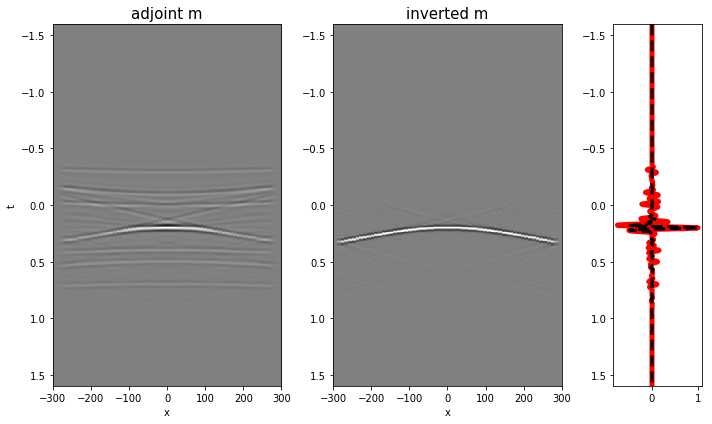

In [6]:
minv,madj,psfinv,psfadj = MDD(Gwav2, d.T, 
                              dt=par['dt'], dr=par['dx'], nfmax=par['nfmax'], wav = wav,
                              twosided=True, add_negative=False, causality_precond=True,
                              adjoint=True, psf=True, dtype='complex64', dottest=True, 
                              **dict(damp=1e-4, iter_lim=30, show=1))

# Plotting
fig = plt.figure(figsize=(10,6))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))
ax1.imshow(madj.T, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-np.max(np.abs(madj)), vmax=np.max(np.abs(madj)), 
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('adjoint m', fontsize=15)
ax1.set_xlabel('x'),ax1.set_ylabel('t')
ax2.imshow(minv.T, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-np.max(np.abs(mwav)), vmax=np.max(np.abs(mwav)), 
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('inverted m', fontsize=15)
ax2.set_xlabel('x'),ax1.set_ylabel('t')
ax3.plot(madj[int(par['nx']/2)]/np.abs(madj[int(par['nx']/2)]).max(), t2, 'r',   lw=5)
ax3.plot(minv[int(par['nx']/2)]/np.abs(minv[int(par['nx']/2)]).max(), t2, '--k', lw=3)
ax3.set_ylim([t2[-1],t2[0]])
fig.tight_layout()